For images--> Pillow, OpenCV<br>
For audio--> scipy, librosa<br>
For text--> raw Python or Cython based loading, or NLTK and SpaCy

For vision there is a package called torchvision. It has data loaders for common datasets such as Imagenet, CIFAR10, MNIST and data transformers via torchvision.datasets and torch.utils.data.DataLoader

Following steps for traning classifier
<ol>
    <li>Load and normalizing the CIFAR10 training and test datasets using torchvision</li>
    <li>Define a CNN</li>
    <li>Define loss function</li>
    <li>Train network on training data</li>
    <li>Test network on test data</li>
</ol>

# Loading an normalizing CIFAR10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

If running on Windows and you get a BrokenPipeError, try setting
the num_worker of torch.utils.data.DataLoader() to 0.

In [2]:
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
trainset=torchvision.datasets.CIFAR10(root='./data',train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


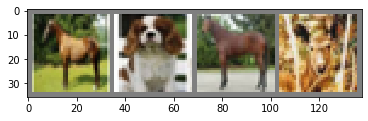

horse   dog horse  deer


In [5]:
#printing some training images
import matplotlib.pyplot as plt
import numpy as np

def imgshow(img):
    img=img/2+0.5 #unnormalize
    npimg=img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()
    
#getting some random training images
dataiter=iter(trainloader)
images, labels=dataiter.next()

#show images
imgshow(torchvision.utils.make_grid(images))

# print labels also
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(' '.join('%5s' %classes[labels[j]] for j in range(4)))

In [7]:
#Defining CNN

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1=nn.Conv2d(3,6,5)
        self.pool=nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(6,16,5)
        self.fc1=nn.Linear(16*5*5,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)
    
    def forward(self, x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=x.view(-1,16*5*5)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x
    
net=Net()
print(net)
        
        

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [9]:
#define loss and optimizer
import torch.optim as optim
criterion =nn.CrossEntropyLoss()
optimizer=optim.SGD(net.parameters(),lr=0.001,momentum=0.9)

In [10]:
#Train the network
for epoch in range(2):
    running_loss=0.0
    for i, data in enumerate(trainloader,0):
        #get input, data is a list of tuple[inputs, labels]
        inputs,labels=data
        
        #zero the parameter gradients
        optimizer.zero_grad()
        
        #forward+backward+optimize
        outputs=net(inputs)
        loss=criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #print statistics
        running_loss +=loss.item()
        if i%2000==1999: #print every 200 mini batches
            print('[%d, %5d] loss: %.3f' %(epoch+1,i+1,running_loss/2000))
            running_loss=0.0
            
print('Finished_training')

[1,  2000] loss: 2.205
[1,  4000] loss: 1.858
[1,  6000] loss: 1.685
[1,  8000] loss: 1.586
[1, 10000] loss: 1.510
[1, 12000] loss: 1.488
[2,  2000] loss: 1.417
[2,  4000] loss: 1.379
[2,  6000] loss: 1.336
[2,  8000] loss: 1.332
[2, 10000] loss: 1.327
[2, 12000] loss: 1.298
Finished_training


In [11]:
# Save our trained model

PATH='./cifar_net.pth'
torch.save(net.state_dict(), PATH)

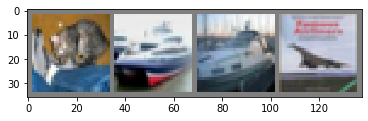

GroundTruth:    cat  ship  ship plane


In [13]:
#Test network on test data

#First display an image from test set to get familiar

dataiter=iter(testloader)
images, labels=dataiter.next()

#print images
imgshow(torchvision.utils.make_grid(images))
print('GroundTruth: ',' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [14]:
#load the model back
net=Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [16]:
#checking what neural netowrk thingks these example above are
outputs=net(images)

In [19]:
_, predicted=torch.max(outputs, 1)
print('Predicted: ',' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:   frog  ship   car plane


In [21]:
#looking at while dataset

correct=0
total=0
with torch.no_grad():
    for data in testloader:
        images,labels=data
        outputs=net(images)
        _, predicted=torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted==labels).sum().item()
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


In [22]:
#what classes predicted well, and what classes did not

class_correct=list(0. for i in range(10))
class_total=list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images,labels=data
        outputs=net(images)
        _, predicted=torch.max(outputs,1)
        c=(predicted==labels).squeeze()
        for i in range(4):
            label=labels[i]
            class_correct[label] +=c[i].item()
            class_total[label] +=1
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 74 %
Accuracy of   car : 65 %
Accuracy of  bird : 26 %
Accuracy of   cat : 36 %
Accuracy of  deer : 47 %
Accuracy of   dog : 46 %
Accuracy of  frog : 80 %
Accuracy of horse : 66 %
Accuracy of  ship : 48 %
Accuracy of truck : 55 %
